In [1]:
!apt-get install swig3.0
!ln -s /usr/bin/swig3.0 /usr/bin/swig
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install stable-baselines3[extra]
!pip install huggingface_hub
!pip install huggingface-sb3
!pip install river

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig3.0
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,109 kB of archives.
After this operation, 5,555 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig3.0 amd64 3.0.12-2.2ubuntu1 [1,109 kB]
Fetched 1,109 kB in 2s (528 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-2.2ubuntu1_amd64.deb ...
Unpacking swig3.0 (3.0.12-2.2ubuntu1) ...
Setting up swig3.0 (3.0.12-2.2ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 2.4 MB/s eta 0:00:00
  Installing

In [2]:
import numpy as np
import pandas as pd

import gymnasium as gym

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.cluster import KMeans

import scipy
from scipy.stats import norm


from huggingface_sb3 import load_from_hub
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import is_wrapped

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LogNorm

from collections import deque

from typing import Tuple

from river import drift

## Load Trained Policy

In [3]:
checkpoint = load_from_hub(
    repo_id = "sb3/sac-Pendulum-v1",
    filename = "sac-Pendulum-v1.zip",
)

model = SAC.load(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sac-Pendulum-v1.zip:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: 'bytes' object cannot be interpreted as an integer
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


## Create Environment

In [5]:
env0 = gym.make("Pendulum-v1", g=10.0) # Training Environment
env1 = gym.make("Pendulum-v1", g=10.0) # Undrifted Environment
env2 = gym.make("Pendulum-v1", g=10.5) # Drifted Environment

## Evaluate Policy on Undrifted and Drifted Environments

In [6]:
evaluate_policy(model, env1, n_eval_episodes=500)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-145.02429038285558, 80.56888766821456)

In [7]:
evaluate_policy(model, env2, n_eval_episodes=500)

(-141.71597472298564, 84.73014091194341)

## Environment Drift Detection

In [9]:
rewards_production = []

env1_step = 3000
env2_step = 3000

total_step = env1_step + env2_step

n_past_steps_to_store = 500
replay_buffer = deque([], maxlen=n_past_steps_to_store)


env_current = env1
obs_t, _ = env_current.reset() # Initialize the environment

for t in range(1, total_step+1):

  if t%500 == 0:
   print(f"step {t}")

  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env_current.step(action_t)
  replay_buffer.append([obs_t, action_t, obs_tplus1, r_tplus1, t])

  rewards_production.append(r_tplus1)

  done = terminated or truncated

  obs_t = obs_tplus1

  if done:
    obs_t, _ = env_current.reset()

  if t==env1_step: ## Environment Drift Happens
    env_current = env2
    obs_t, _ = env_current.reset()


rewards_production = np.array(rewards_production)

step 500
step 1000
step 1500
step 2000
step 2500
step 3000
step 3500
step 4000
step 4500
step 5000
step 5500
step 6000


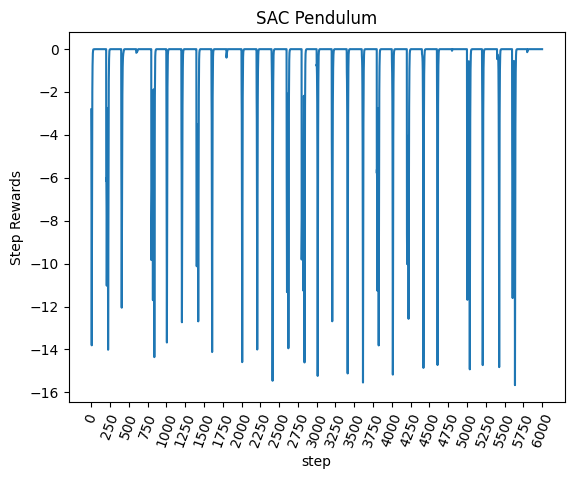

In [11]:
plt.plot(np.array(rewards_production))
plt.xlabel("step")
plt.ylabel("Step Rewards")
plt.xticks(np.arange(0, 6001, 250), rotation=70)
plt.title("SAC Pendulum")
plt.show()

### Environment Drift Detection with Prob-CUSUM

In [12]:
class CusumMeanDetector():
  def __init__(self, mu_ref, sigma_ref, obs_ref, p_limit=0.01) -> None:
    self._mu_ref = mu_ref
    self._sigma_ref = sigma_ref
    self._p_limit = p_limit

    self._reset(obs_ref)

  def _reset(self, obs_ref) -> None:
    self.current_t = len(obs_ref)
    self.current_obs = obs_ref.copy()
    #self.mu_current = self._mu_ref
    #self.sigma_current = self._sigma_ref

  def _update_data(self, y:float) -> None:
    self.current_t += 1
    self.current_obs.append(y)

  def _get_pvalue(self, y, alternative="two-sided") -> float:
    assert alternative in {"two-sided", "greater", "less"}
    pcum = scipy.stats.norm.cdf(y, loc=0., scale=1.)
    if alternative == "two-sided":
      p = 2*(1-pcum)
    if alternative == "greater":
      p = 1-pcum
    if alternative == "less":
      p = pcum
    return p

  def _check_for_changepoint(self, alternative) -> Tuple[float, bool]:
    standardized_sum = np.sum(np.array(self.current_obs)-self._mu_ref)/(self._sigma_ref*self.current_t**0.5)
    p = self._get_pvalue(standardized_sum, alternative)
    return p, p < self._p_limit


  def predict_next(self, y, alternative="two-sided") -> Tuple[float, bool]:
    self._update_data(y)
    p, is_changepoint = self._check_for_changepoint(alternative)
    return p, is_changepoint

In [13]:
# Environment Drift Detection with CUSUM
env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref=sigma_ref,
                                   obs_ref=rewards_reference_window,
                                   p_limit = p_limit)


delay = 4000
false_alarms = 0

for i,val in enumerate(rewards_production):
  #drift_detector.add_data_point(val)
  p_value, drift_detected = drift_detector.predict_next(val, alternative="less")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val}")
    rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()
    drift_detector._reset(rewards_reference_window)
    if i < 3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Positives: {false_alarms}, Delay: {delay}")

Drift Detected at: 6 with value: -12.192115187816922
Drift Detected at: 223 with value: -9.224646385231297
Drift Detected at: 841 with value: -12.255562642445819
Drift Detected at: 1430 with value: -3.9449871177181524
Drift Detected at: 2839 with value: -13.260585712928432
Drift Detected at: 3827 with value: -10.190598318360438
False Positives: 5, Delay: 827


#### Monitor Average Step Rewards

In [14]:
# Environment Drift Detection with CUSUM
env0_steps = 4000

episode_length = 100
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()

drift_detector = CusumMeanDetector(mu_ref=mu_ref,
                                   sigma_ref=sigma_ref,
                                   obs_ref=rewards_reference_window,
                                   p_limit = p_limit)

false_alarms = 0
delay = 4000


for i,val in enumerate(rewards_production):
  #drift_detector.add_data_point(val)
  episode_deque.append(val)
  val_avg = np.mean(episode_deque)
  p_value, drift_detected = drift_detector.predict_next(val_avg, alternative="less")
  if drift_detected:
    print(f"Drift Detected at: {i} with value: {val_avg}")
    rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()
    drift_detector._reset(rewards_reference_window)
    if i < 3000:
      false_alarms+=1
    if i >= 3000:
      delay = i-3000
      break

print(f"False Positives: {false_alarms}, Delay: {delay}")

Drift Detected at: 59 with value: -1.1515449378575482
Drift Detected at: 104 with value: -0.9148131211911505
Drift Detected at: 267 with value: -2.370216804237627
Drift Detected at: 272 with value: -2.3702047542748694
Drift Detected at: 273 with value: -2.3702047683279974
Drift Detected at: 282 with value: -2.370187335512633
Drift Detected at: 290 with value: -2.370176678334008
Drift Detected at: 299 with value: -2.370168473557059
Drift Detected at: 305 with value: -1.9645820629215358
Drift Detected at: 892 with value: -3.3712883738878974
Drift Detected at: 896 with value: -3.371290811862867
Drift Detected at: 904 with value: -2.9037334597615914
Drift Detected at: 911 with value: -2.4228711781508965
Drift Detected at: 914 with value: -2.2674364505396327
Drift Detected at: 921 with value: -1.7125402772398892
Drift Detected at: 1088 with value: -1.145443813870127
Drift Detected at: 1099 with value: -1.1454375017647591
Drift Detected at: 1100 with value: -1.1172961907158703
Drift Detected

### Page-Hinkley

In [15]:
ph = drift.PageHinkley(mode="down", delta=0.005)

env0_steps = 4000
rewards_reference = []

obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  ph.update(val)
  if ph.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 222, input value: -2.6327465108275407
Change detected at index 818, input value: -2.771526466582077
Change detected at index 1421, input value: -2.9050668064259946
Change detected at index 2213, input value: -2.184634962829698
Change detected at index 2613, input value: -0.8939678532949122
Change detected at index 2819, input value: -3.645013484760565
Change detected at index 3821, input value: -2.031997633358909
False Alarms: 6, Delay: 821


In [16]:
ph = drift.PageHinkley(mode="down", delta=0.005)

env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  ph.update(val)
  if ph.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 268, input value: -1.3861344292705713
Change detected at index 852, input value: -2.4302361667644345
Change detected at index 1528, input value: -1.3502015893950365
Change detected at index 2208, input value: -0.14588039087338642
Change detected at index 2658, input value: -1.2375254700931808
Change detected at index 2887, input value: -2.377145514530552
Change detected at index 3878, input value: -1.3671850140030846
False Alarms: 6, Delay: 878


### ADWIN

In [17]:
adwin = drift.ADWIN()

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  adwin.update(val)
  if adwin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 831, input value: -0.5619960838104325
Change detected at index 2847, input value: -0.4056065962706457
False Alarms: 2, Delay: 4000


In [18]:
adwin = drift.ADWIN()

env0_steps = 4000

episode_length = 200
episode_deque = deque([], maxlen=episode_length)

rewards_reference = []

obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  adwin.update(val)
  if adwin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 255, input value: -0.8852194343072142
Change detected at index 863, input value: -1.9713089639004968
Change detected at index 1471, input value: -0.8481715184839806
Change detected at index 2623, input value: -0.06954825813311281
Change detected at index 2879, input value: -1.9068997299997028
Change detected at index 3839, input value: -0.8592098180189612
False Alarms: 5, Delay: 839


### KSWIN

In [19]:
kswin = drift.KSWIN()

env0_steps = 4000
rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  rewards_reference.append(r_tplus1)
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()

mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)
#rewards_reference_window = np.random.choice(rewards_reference, size=200, replace=False).tolist()


false_alarms = 0
delay = 4000

rewards_production_norm = (rewards_production-mu_ref)/sigma_ref

for i, val in enumerate(rewards_production_norm):
  kswin.update(val)
  if kswin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 2007, input value: -3.992844509363353
Change detected at index 2213, input value: -2.1199351998651985
Change detected at index 2420, input value: -0.7557777512440396
Change detected at index 2620, input value: -2.247222344418236
Change detected at index 2820, input value: -4.236710212889293
Change detected at index 3020, input value: -0.7822061076843153
False Alarms: 5, Delay: 20


In [20]:
kswin = drift.KSWIN()

env0_steps = 4000

episode_length = 200

episode_deque = deque([], maxlen=episode_length)

rewards_reference = []
p_limit = 0.05
obs_t, _ = env0.reset()
for t in range(env0_steps):
  action_t, _state = model.predict(obs_t, deterministic=True)
  obs_tplus1, r_tplus1, terminated, truncated, info = env0.step(action_t)
  episode_deque.append(r_tplus1)
  if len(episode_deque)==episode_length:
      rewards_reference.append(np.mean(episode_deque))
  done = terminated or truncated
  obs_t = obs_tplus1
  if done:
    obs_t, _ = env0.reset()



mu_ref = np.mean(rewards_reference)
sigma_ref = np.std(rewards_reference, ddof=1)


rewards_production_average = []

for reward in rewards_production:
  #drift_detector.add_data_point(val)
  episode_deque.append(reward)
  reward_average = np.mean(episode_deque)
  rewards_production_average.append(reward_average)

rewards_production_average_norm = (rewards_production_average-mu_ref)/sigma_ref

false_alarms = 0
delay = 4000

for i, val in enumerate(rewards_production_average_norm):
  kswin.update(val)
  if kswin.drift_detected and val<0:
    print(f"Change detected at index {i}, input value: {val}")
    if i<3000:
      false_alarms+=1
    if i>=3000:
      delay = i-3000
      break

print(f"False Alarms: {false_alarms}, Delay: {delay}")

Change detected at index 299, input value: -1.3809569559722072
Change detected at index 399, input value: -1.3809362351488759
Change detected at index 899, input value: -2.8494210189566687
Change detected at index 999, input value: -2.8494300133634005
Change detected at index 1499, input value: -1.3309184274019572
Change detected at index 1599, input value: -1.3309209805824
Change detected at index 2699, input value: -1.1739209330497025
Change detected at index 2799, input value: -1.173923591395015
Change detected at index 2899, input value: -2.762023106884859
Change detected at index 2999, input value: -2.761702431683008
Change detected at index 3899, input value: -1.3546092924578093
False Alarms: 10, Delay: 899
